<DIV ALIGN=CENTER>

# MSCA 37014 Assignment3
## Team Member:  Amily Huang, Duo Zhou and Dylan Zhang
    

  
</DIV>  

-----

**In this notebook, we are using the Employment-Based Immigration Data to do the logistic regression analysis and to figure out the important features that will affect the application result. Our analysis process are:**
<ul>
 <li>Data Exploration</li>
 <li>Pre Processing Data</li>
 <li>Logistic Regression</li>
 <li>Important Features</li>
 </ul>
 
-----

# <font color=#15265E> Getting External Libraries </font>

In [1]:
import pandas as pd  # data frame operations  
import numpy as np  # arrays and math functions
import seaborn as sb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
import scikitplot as scplt
from sklearn.metrics import accuracy_score
import seaborn as sns
np.set_printoptions(precision=3)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import squarify 
import pandas_profiling

# <font color=#15265E> Data Exploration </font>

In [2]:
dat=pd.read_csv('PERM_FY2020_Q3.csv')

**Overview of the Case_Status variable**
<br>

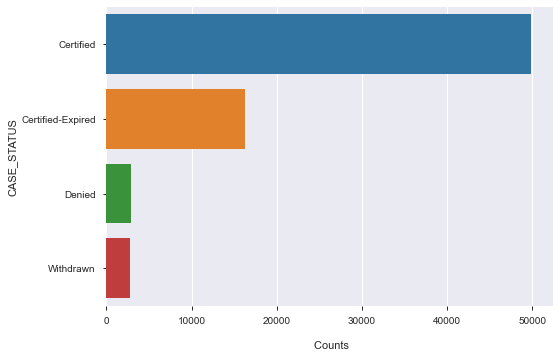

In [3]:
case_status_count = dat.groupby(['CASE_STATUS']).size().reset_index(name='counts')
sns.barplot(data=case_status_count, x = 'counts', y= 'CASE_STATUS').set(xlabel='\n Counts', )
plt.show()

As we can see from the plot, certified case status account for the largest proportion.


-----

**Overview of the count of applications by employer**
<br>

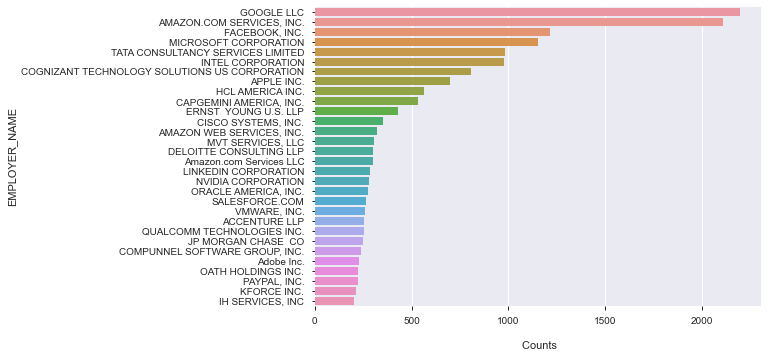

In [4]:
employer_count = dat.groupby(['EMPLOYER_NAME']).size().reset_index(name='counts')
employer_count_top = employer_count[employer_count['counts']>200].sort_values('counts', ascending=False)
sns.barplot(data=employer_count_top, x = 'counts', y= 'EMPLOYER_NAME').set(xlabel='\n Counts', )
plt.show()

According to the plot above, we can see that Google and Amazon submitted the most applications since 2009

-----

**Overview of the Class_Of_Admission variable**
<br>

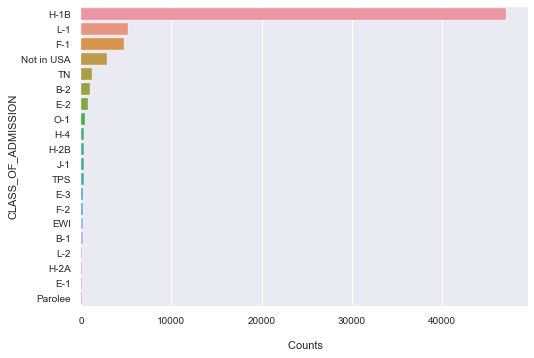

In [5]:
class_admission_count = dat.groupby(['CLASS_OF_ADMISSION']).size().reset_index(name='counts')
class_admission_count = class_admission_count[class_admission_count['counts'] > 100].sort_values(by = 'counts', ascending = False)
sns.set_style('darkgrid')
sns.barplot(data = class_admission_count, x= 'counts', y='CLASS_OF_ADMISSION').set(xlabel='\n Counts', )
plt.show()

Most of the employers are applying for H-1B visa


-----
**Overview of selected variables**
<br>

In [6]:
dat_profiling=dat[[ 'CASE_STATUS','PW_WAGE', 'REQUIRED_EXPERIENCE','REQUIRED_TRAINING','MINIMUM_EDUCATION','PROFESSIONAL_OCCUPATION','APP_FOR_COLLEGE_U_TEACHER']]
dat_profiling.profile_report()

According to the report above, we can see that
<ul>
 <li> Case_Status has the highest correlation with PROFESSIONAL_OCCUPATION</li>
 <li> There are categorical variables → Create dummy variables</li>
 <li> There are missing values → Clean data </li>
 </ul>
 
-----

# <font color=#15265E> Pre Processing Data </font>

**Defining Dummy variables for Student variable,and concatenate the dummy columns with original dataframe.**


In [7]:
dat.head()

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,REFILE,ORIG_FILE_DATE,PREVIOUS_SWA_CASE_NUMBER_STATE,SCHD_A_SHEEPHERDER,EMPLOYER_NAME,EMPLOYER_ADDRESS_1,...,FOREIGN_WORKER_ALT_OCC_EXP,FOREIGN_WORKER_EXP_WITH_EMPL,FOREIGN_WORKER_EMPL_PAY_FOR_ED,FOREIGN_WORKER_CURR_EMPLOYED,EMPLOYER_COMPLETED_APPLICATION,PREPARER_NAME,PREPARER_TITLE,PREPARER_EMAIL,EMP_INFO_DECL_NAME,EMP_INFO_DECL_TITLE
0,A-09245-62715,Denied,9/3/09,4/30/20,N,NaN,NaN,N,SATURN ENTERPRISES INC,2340 N WASHTENAW AVE,...,NaN,N,N,N,N,Christopher E Kurczaba,Attorney,kurczabalaw@sbcglobal.net,Zygmunt Oparowski,President
1,A-10119-96737,Certified-Expired,3/29/10,10/18/19,Y,9/15/00,MARYLAND,N,FIL PARONG,13528 JAMIESON PL,...,NaN,N,N,N,N,WINSTON W TSAI,ATTORNEY AT LAW,WINSTONTSAI@AOL.COM,FIL PARONG,HEAD OF HOUSEHOLD
2,A-10225-13679,Denied,8/10/10,4/30/20,N,NaN,NaN,N,GLENNS PLUMBING SERVICES,854 CUSTER STREET,...,N,N,N,N,N,DANIEL J SULLIVAN,ATTORNEY,GWG8@AOL.COM,DAVID GLENN,OWNER
3,A-11033-51540,Certified,2/3/11,5/28/20,N,NaN,NaN,N,SKILLNET SOLUTIONS INC.,1901 SOUTH BASCOM AVENUE,...,Y,N,N,Y,N,Sonal Kinger,Attorney at Law,sonal.kinger@bakerlawcorp.com,Jack Grover,VP of Finance and Operations
4,A-11074-62984,Denied,3/10/11,6/17/20,N,NaN,NaN,N,"R L CONSTRUCTION, INC.",904 NEPPERHAN AVENUE,...,NaN,N,N,N,N,DENISE S DUTTON,NONATTORNEY,NaN,RITA O SULLIVAN,MANAGER


#### Change the response varaible (CASE_STATUS) categories into only two levels: Certified vs Not_Certified

In [8]:
dat['CASE_STATUS_BI']=0
# change the response categories into only two levels: certifies vs denied
dat.loc[(dat['CASE_STATUS']=='Certified-Expired'),'CASE_STATUS_BI']='Certified'
dat.loc[(dat['CASE_STATUS']=='Certified'),'CASE_STATUS_BI']='Certified'
dat.loc[(dat['CASE_STATUS']=='Denied'),'CASE_STATUS_BI']='Not_Certified'
dat.loc[(dat['CASE_STATUS']=='Withdrawn'),'CASE_STATUS_BI']='Not_Certified'
dat['CASE_STATUS_BI'].unique()

array(['Not_Certified', 'Certified'], dtype=object)


-----

**Select variables**

<br>

<li>We chose CASE_STATUS as response variable.</li>
    <li> Variables regarding to the type of professions, wage, education requirement, experience and training requirement are chosen as predictor variables </li> 
    
*Note: all wages are normalized to hourly wages and NAs are dropped*

In [9]:
dat['CASE_STATUS_BI'] = pd.get_dummies(dat['CASE_STATUS_BI'])
dat['REQUIRED_TRAINING'] = pd.get_dummies(dat['REQUIRED_TRAINING'])
dat['REQUIRED_EXPERIENCE'] = pd.get_dummies(dat['REQUIRED_EXPERIENCE'])
dat['PROFESSIONAL_OCCUPATION'] = pd.get_dummies(dat['PROFESSIONAL_OCCUPATION'])
dat['APP_FOR_COLLEGE_U_TEACHER']=pd.get_dummies(dat['APP_FOR_COLLEGE_U_TEACHER'])
dat['MINIMUM_EDUCATION'] = pd.get_dummies(dat['MINIMUM_EDUCATION'])
dat['PW_WAGE'] = dat['PW_WAGE'].str[1:].replace(',','', regex=True).astype(float)
dat = dat.dropna(subset = ['PW_WAGE'])
# convert all wages to hourly unit
dat.loc[dat['PW_UNIT_OF_PAY'] == "Year",'PW_WAGE'] = dat['PW_WAGE']/(37.5*52)

In [10]:
dat_select=pd.DataFrame()
dat_select=dat[[ 'CASE_STATUS_BI','PW_WAGE',
            'REQUIRED_EXPERIENCE','REQUIRED_TRAINING','MINIMUM_EDUCATION',
            'PROFESSIONAL_OCCUPATION','APP_FOR_COLLEGE_U_TEACHER']]
# Drop all NA values
dat_select.dropna(axis='rows')
dat_select.isnull().values.any() # Check for NA values

False

In [11]:
dat_select=dat_select[[ 'CASE_STATUS_BI','REQUIRED_TRAINING', 'PW_WAGE',
            'REQUIRED_EXPERIENCE','MINIMUM_EDUCATION',
            'PROFESSIONAL_OCCUPATION','APP_FOR_COLLEGE_U_TEACHER']]
dat_select

,CASE_STATUS_BI,REQUIRED_TRAINING,PW_WAGE,REQUIRED_EXPERIENCE,MINIMUM_EDUCATION,PROFESSIONAL_OCCUPATION,APP_FOR_COLLEGE_U_TEACHER
0,0,1,14.490000,0,0,1,1
1,1,1,19.360000,1,0,1,1
2,0,1,40.330769,0,0,1,1
3,1,1,67.445128,0,0,0,1
4,0,1,27.509231,0,0,1,1
...,...,...,...,...,...,...,...
71937,0,1,10.997436,1,0,1,1
71938,0,1,45.077436,0,0,0,1
71939,0,1,65.322564,0,0,0,1
71940,0,1,49.898462,0,0,1,1


-----

# <font color=#15265E> Logistic Regression for Case Status based on Selected Variables </font>

In [12]:
mymodel= LogisticRegression(C=100000000)
X = dat_select.loc[:, dat_select.columns != 'CASE_STATUS_BI']
y = dat['CASE_STATUS_BI']
my_results = mymodel.fit(X,y)
my_results.score(X, y)

0.9209414185225345

In [13]:
print("The coefficients are", my_results.coef_, "\n")
print("The Intercepts are", my_results.intercept_,"\n")
my_results.get_params()
my_results.predict(X)
my_results.predict_log_proba(X)
my_results.predict_proba(X)

The coefficients are [[ 1.076e+00 -3.969e-05 -7.129e-02 -4.267e-01 -1.670e+00 -1.614e+00]] 

The Intercepts are [3.475] 



array([[0.22 , 0.78 ],
       [0.233, 0.767],
       [0.22 , 0.78 ],
       ...,
       [0.051, 0.949],
       [0.22 , 0.78 ],
       [0.051, 0.949]])

The size of the training set predictors is  (50353, 6)
The size of the training set response is  (50353,)
The size of the test set predictors is  (21581, 6)
The size of the test set response is  (21581,)
[[    2  1725]
 [    0 19854]]
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      1727
           1       0.92      1.00      0.96     19854

    accuracy                           0.92     21581
   macro avg       0.96      0.50      0.48     21581
weighted avg       0.93      0.92      0.88     21581



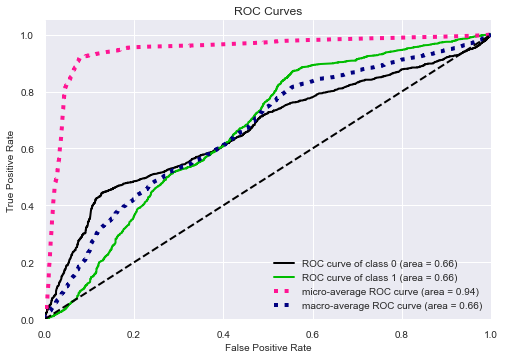

The AUC Value for the model is 0.6635982918501353
The Classification table is 
 [[    2  1725]
 [    0 19854]]
True Positive rate is 100 %
False Positive rate is 99.88419224088014 %
Model Accuracy is 0.9200685788425004


In [14]:
pr_train, pr_test, resp_train, resp_test = train_test_split(
        X, y, test_size=0.3, random_state=31171)

print('The size of the training set predictors is ', pr_train.shape)
print('The size of the training set response is ', resp_train.shape)
print('The size of the test set predictors is ', pr_test.shape)
print('The size of the test set response is ', resp_test.shape)

my_results_train = mymodel.fit(pr_train,resp_train)
predictions_test=my_results_train.predict(pr_test)
cm=confusion_matrix(resp_test, predictions_test)
print(cm)
print(classification_report(resp_test, predictions_test))

my_results_train = mymodel.fit(pr_train,resp_train)
predictions_test=my_results_train.predict(pr_test)
predictions_test_prob=my_results_train.predict_proba(pr_test)

fpr, tpr, tholds = metrics.roc_curve(resp_test, predictions_test_prob[:,1], pos_label = 1)
scplt.metrics.plot_roc(resp_test, predictions_test_prob)
plt.show()

print("The AUC Value for the model is", metrics.auc(fpr, tpr))
print("The Classification table is \n", confusion_matrix(resp_test, predictions_test))
print('True Positive rate is', 100,'%')
print('False Positive rate is',1725/1727*100,'%')
print('Model Accuracy is',accuracy_score(resp_test, predictions_test))

The accuracy for the holdout test is 92%. The True positive rate is very high at 100% out model False positive rate is also very high at 99%. This is due to the imbalanced proportion of Certified and Non-Certified respose values. 


-----

# <font color=#15265E> Feature Importance of Selected Predictors

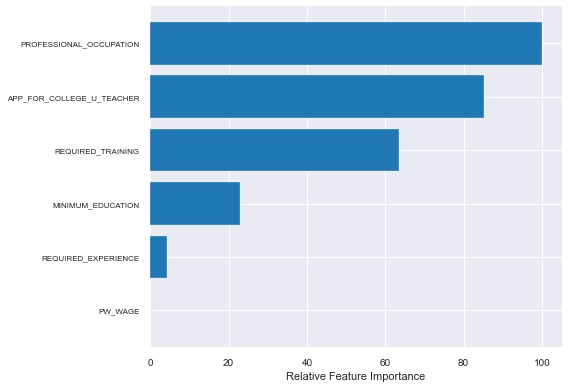

In [15]:
feature_importance = abs(mymodel.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

#### Let us take a look at how each feature effect the certification result

<font color= #424646 > ‣ PROFESSIONAL_OCCUPATION </font>

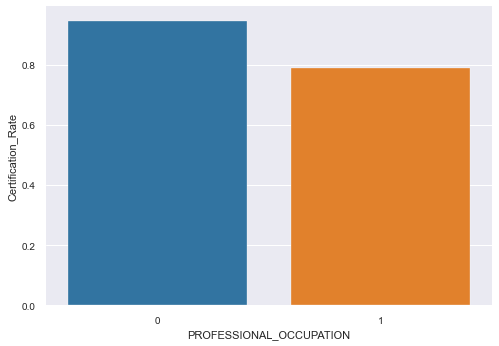

In [16]:
number_p=dat_select['CASE_STATUS_BI'].groupby(by = dat_select['PROFESSIONAL_OCCUPATION']).sum()
size_p=dat_select['CASE_STATUS_BI'].groupby(by = dat_select['PROFESSIONAL_OCCUPATION']).size()
per_p=(number_p/size_p).reset_index(name='Certification_Rate')
sns.barplot(data=per_p, x = 'PROFESSIONAL_OCCUPATION', y= 'Certification_Rate').set(xlabel='PROFESSIONAL_OCCUPATION')
plt.show()

Jobs considered as professional occupations(0) has higher chance to get certified than non professional occupations(1).

-----

<font color= #424646 >  ‣ APP_FOR_COLLEGE_U_TEACHER </font>

,APP_FOR_COLLEGE_U_TEACHER,Certification_Rate
0,0,0.938764
1,1,0.920331


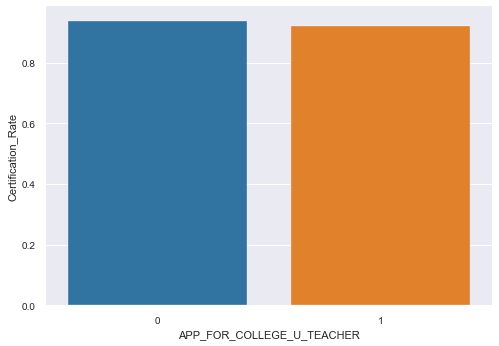

In [17]:
number_p1=dat_select['CASE_STATUS_BI'].groupby(by = dat_select['APP_FOR_COLLEGE_U_TEACHER']).sum()
size_p1=dat_select['CASE_STATUS_BI'].groupby(by = dat_select['APP_FOR_COLLEGE_U_TEACHER']).size()
per_p1=(number_p1/size_p1).reset_index(name='Certification_Rate')
sns.barplot(data=per_p1, x = 'APP_FOR_COLLEGE_U_TEACHER', y= 'Certification_Rate').set(xlabel='APP_FOR_COLLEGE_U_TEACHER', )
per_p1

College and University teachers get very simialr certification rate than those who are not.

-----

<font color= #424646 >  ‣ REQUIRED_TRAINING </font>

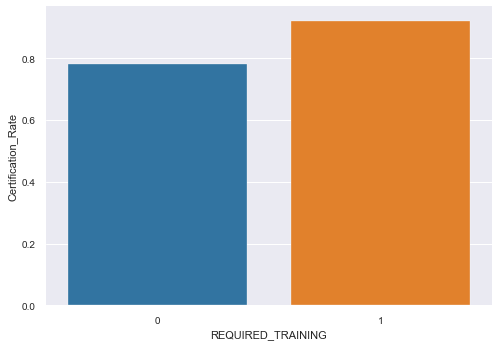

In [18]:
number_p2=dat_select['CASE_STATUS_BI'].groupby(by = dat_select['REQUIRED_TRAINING']).sum()
size_p2=dat_select['CASE_STATUS_BI'].groupby(by = dat_select['REQUIRED_TRAINING']).size()
per_p2=(number_p2/size_p2).reset_index(name='Certification_Rate')
sns.barplot(data=per_p2, x = 'REQUIRED_TRAINING', y= 'Certification_Rate').set(xlabel='REQUIRED_TRAINING')
plt.show()

Jobs do not require training(1) has higher chance to get certified than jobs required training(0).

-----

<font color= #424646 > ‣ PW_WAGE </font>

,CASE_STATUS_BI,AVG WAGE
0,0,47.346604
1,1,48.272604


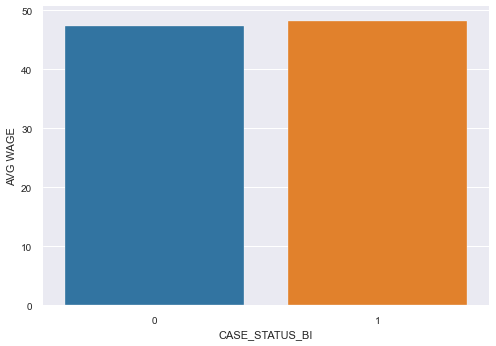

In [19]:
mean_wage = dat_select['PW_WAGE'].groupby(by = dat_select['CASE_STATUS_BI']).mean().reset_index(name='AVG WAGE')
sns.barplot(data=mean_wage, x = 'CASE_STATUS_BI', y= 'AVG WAGE').set(xlabel='CASE_STATUS_BI', )
mean_wage

On average, people who do get certified do not have much higher income than who do not get certified. Income is not a significant factor in terms of getting the certification. 

-----

<font color= #424646 > ‣ MINIMUN EDUCATION </font>

In [20]:
dat1=pd.read_csv('PERM_FY2020_Q3.csv')
dat1['CASE_STATUS_BI']=0
# change the response categories into only two levels: certifies vs denied
dat1.loc[(dat1['CASE_STATUS']=='Certified-Expired'),'CASE_STATUS_BI']='Certified'
dat1.loc[(dat1['CASE_STATUS']=='Certified'),'CASE_STATUS_BI']='Certified'
dat1.loc[(dat1['CASE_STATUS']=='Denied'),'CASE_STATUS_BI']='Not_Certified'
dat1.loc[(dat1['CASE_STATUS']=='Withdrawn'),'CASE_STATUS_BI']='Not_Certified'
dat1['CASE_STATUS_BI'].unique()


array(['Not_Certified', 'Certified'], dtype=object)

In [21]:
dat1.loc[dat1.MINIMUM_EDUCATION.isnull(),'MINIMUM_EDUCATION']='None'
dat1['MINIMUM_EDUCATION'].unique()

array(['High School', 'None', "Bachelor's", 'Other', "Master's",
       'Doctorate', "Associate's"], dtype=object)

In [22]:
dat1['CASE_STATUS_BI']=='Certified'

0        False
1         True
2        False
3         True
4        False
         ...  
71937    False
71938    False
71939    False
71940    False
71941    False
Name: CASE_STATUS_BI, Length: 71942, dtype: bool

,MINIMUM_EDUCATION,Certification_Rate
4,Master's,0.956434
2,Doctorate,0.949015
1,Bachelor's,0.942984
6,Other,0.903704
0,Associate's,0.797251
5,None,0.777187
3,High School,0.743335


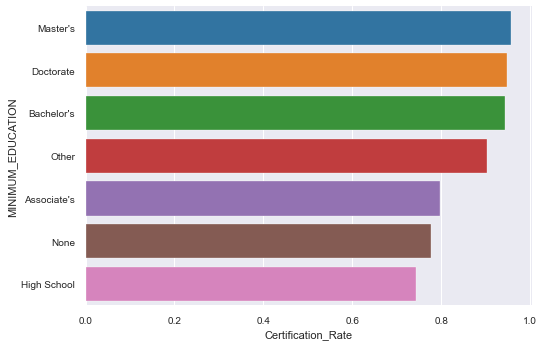

In [23]:
number_p3=dat1.loc[dat1['CASE_STATUS_BI']=='Certified','CASE_STATUS_BI'].groupby(by = dat1['MINIMUM_EDUCATION']).size().sort_values()
size_p3=dat1['CASE_STATUS_BI'].groupby(by = dat1['MINIMUM_EDUCATION']).size()
per_p3=(number_p3/size_p3).reset_index(name='Certification_Rate').sort_values('Certification_Rate', ascending=False)
sns.barplot(data=per_p3, y = 'MINIMUM_EDUCATION', x= 'Certification_Rate').set(xlabel='Certification_Rate' )
per_p3


In general for those who have Bachelor's or above degrees, the visa certification rate is very high(around 95%). Based on the data there seems to be no distinction between people with undergraduate and graduate degrees. The certification rate drops a lot for those who do not have a college level or higher degrees. 

----

# <font color=#15265E> Conclusion </font>

<li>This is not a clean data set. We have to clean and handle missing values before using this data set to do analysis. </li> <br>
<li>Even though the holdout test accuracy of our logistic regression analysis is significantly high, this data set is not good for supervised regression due to imbalanced proportion of response values</li> <br>
<li> PROFESSIONAL_OCCUPATION, APP_FOR_COLLEGE_U_TEACHER, and REQUIRE_TRAINING variables are the most important features. However, The response among these 3 variables does not have significant difference. 